#### Importa√ß√£o dos Dados e Prepara√ß√£o Inicial

Carregamos o dataset de transa√ß√µes financeiras e realizamos a primeira c√≥pia para preservar a vers√£o original.  
Essa etapa √© fundamental para garantir rastreabilidade e evitar altera√ß√µes indesejadas nos dados brutos.  
Tamb√©m iniciamos uma inspe√ß√£o inicial com `.head()` e `.info()` para entender a estrutura e as vari√°veis presentes no conjunto.

In [29]:
# Importa√ß√£o de bibliotecas.
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter


from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [30]:
df_raw = pd.read_csv("transactions.csv")

In [31]:
# Foi feito uma c√≥pia do dataset original para preservar a vers√£o bruta.
df = df_raw.copy()

In [32]:
# Visualiza√ß√£o de amostras.
df.head(7)

step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     8  CASH_OUT  158007.12   C424875646           0.00            0.00   
1   236  CASH_OUT  457948.30  C1342616552           0.00            0.00   
2    37   CASH_IN  153602.99   C900876541    11160428.67     11314031.67   
3   331  CASH_OUT   49555.14   C177696810       10865.00            0.00   
4   250  CASH_OUT   29648.02   C788941490           0.00            0.00   
5   182   PAYMENT   15712.66   C365217190       13981.00            0.00   
6   355   PAYMENT     357.15  C1752574405      283349.71       282992.56   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  C1298177219       474016.32      1618631.97        0  
1  C1323169990      2720411.37      3178359.67        0  
2   C608741097      3274930.56      3121327.56        0  
3   C462716348            0.00        49555.14        0  
4  C1971700992        56933.09        86581.10        0  
5  M1108542644            0.00            0.00        0  
6   M807801422            0.00            0.00        0

In [33]:
# Analisamos os tipos e a quantidade de valores √∫nicos por coluna.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            199999 non-null  int64  
 1   type            199999 non-null  object 
 2   amount          199999 non-null  float64
 3   nameOrig        199999 non-null  object 
 4   oldbalanceOrg   199999 non-null  float64
 5   newbalanceOrig  199999 non-null  float64
 6   nameDest        199999 non-null  object 
 7   oldbalanceDest  199999 non-null  float64
 8   newbalanceDest  199999 non-null  float64
 9   isFraud         199999 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 15.3+ MB


In [34]:
# Isso ajuda a identificar colunas que podem ser descartadas ou tratadas.
df.nunique()

step                 524
type                   5
amount            198565
nameOrig          199990
oldbalanceOrg      98238
newbalanceOrig     86422
nameDest          174523
oldbalanceDest    114777
newbalanceDest    122915
isFraud                2
dtype: int64

#### An√°lise Inicial da Vari√°vel Alvo e Comportamento de Fraudes

Antes da modelagem, exploramos a vari√°vel `isFraud` para entender o desequil√≠brio entre classes, algo comum em detec√ß√£o de fraudes.  
Verificamos tamb√©m se h√° **destinat√°rios reincidentes**, o que pode indicar contas suspeitas ou alvos frequentes.  
Por fim, comparamos o total de transa√ß√µes com o n√∫mero de fraudes por tipo de opera√ß√£o.


In [35]:
# Classe majorit√°ria domina o dataset ('isFraud' = 0), o que pode causar sobreajuste e exige balanceamento para uma modelagem eficaz.
df['isFraud'].value_counts()

isFraud
0    199717
1       282
Name: count, dtype: int64

In [36]:
# Criamos uma lista para filtragem dos nomes que contem fraudes confirmadas.
fraud_y = df[df['isFraud'] == 1]['nameDest'].tolist()

count = Counter(fraud_y)

if any(qtd >= 2 for qtd in count.values()):
    print("H√° reincid√™ncia em fraudes com o mesmo destinat√°rio.")
else:
    print("N√£o h√° reincid√™ncia em fraudes com o mesmo destinat√°rio.")

N√£o h√° reincid√™ncia em fraudes com o mesmo destinat√°rio.


#### Compara√ß√£o entre Volume Total e Fraudes por Tipo de Transa√ß√£o

Aqui comparamos o n√∫mero total de transa√ß√µes com o n√∫mero de transa√ß√µes fraudulentas, categorizadas por tipo (`CASH_OUT`, `TRANSFER`, etc).  
Esse gr√°fico facilita a visualiza√ß√£o de **quais tipos s√£o mais vulner√°veis a fraudes**, mesmo quando representam uma fatia menor do volume total.  
Al√©m disso, adicionamos o percentual de fraude por tipo, fornecendo contexto sobre a gravidade relativa de cada categoria.


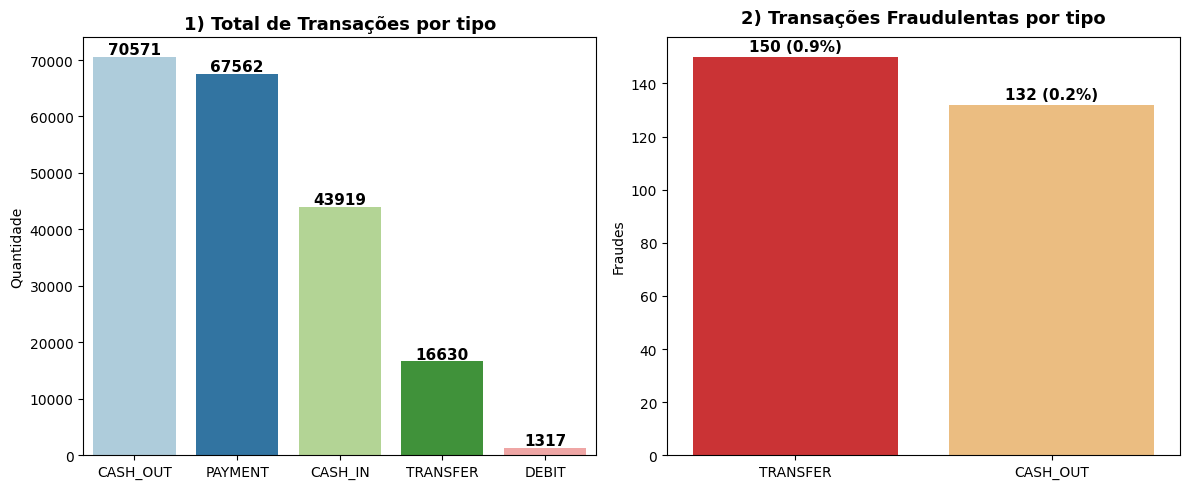

In [37]:
# Comparando o total de transa√ß√µes com as transa√ß√µes fraudulentas por tipo.
tot_type = df["type"].value_counts()
fraud_type = df[df["isFraud"] == 1]["type"].value_counts()
pct_type = (fraud_type / tot_type * 100).round(1)

# Paletas de cores para diferenciar os dois gr√°ficos
plt_total = ["#A6CEE3", "#1F78B4", "#B2DF8A", "#33A02C", "#FB9A99"]
plt_fraud = ["#E31A1C", "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A"]

plt.figure(figsize=(12, 5))

# Gr√°fico 1 - Total de transa√ß√µes por tipo
plt.subplot(1, 2, 1)
sns.barplot(x=tot_type.index, y=tot_type.values, hue=tot_type.index, palette=plt_total[:len(tot_type)], legend=False)
plt.title("1) Total de Transa√ß√µes por tipo", fontsize=13, fontweight="bold")
plt.ylabel("Quantidade")
plt.xlabel("")
plt.xticks(rotation=0)
for i, v in enumerate(tot_type.values):
    plt.text(i, v + 500, f"{v}", ha="center", fontsize=11, fontweight="bold")

# Gr√°fico 2 - Transa√ß√µes fraudulentas por tipo
plt.subplot(1, 2, 2)
sns.barplot(x=fraud_type.index, y=fraud_type.values, hue=fraud_type.index, palette=plt_fraud[:len(fraud_type)], legend=False)
plt.title("2) Transa√ß√µes Fraudulentas por tipo", fontsize=13, fontweight="bold", pad=10)
plt.ylabel("Fraudes")
plt.xlabel("")
plt.xticks(rotation=0)
for i, v in enumerate(fraud_type.values):
    pct = pct_type[fraud_type.index[i]]
    plt.text(i, v + 2, f"{v} ({pct}%)", ha="center", fontsize=11, fontweight="bold")

# Ajuste para evitar sobreposi√ß√£o
plt.tight_layout()
plt.show()


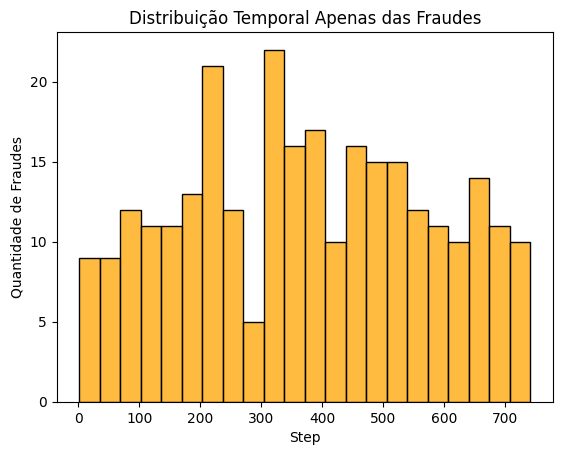

In [38]:
# Aqui visualizamos em quais per√≠odos (steps) ocorreram mais fraudes ao longo da simula√ß√£o.
# Isso ajuda a identificar picos de atividade fraudulenta e padr√µes temporais de risco.
sns.histplot(data=df[df['isFraud'] == 1], x='step', bins=22, color='orange')
plt.title('Distribui√ß√£o Temporal Apenas das Fraudes')
plt.xlabel('Step')
plt.ylabel('Quantidade de Fraudes');

<Axes: >

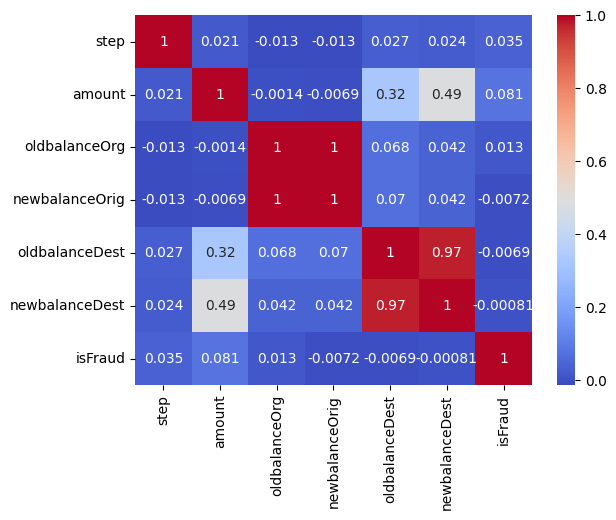

In [39]:
# O gr√°fico mostra que n√£o h√° vari√°veis com forte correla√ß√£o direta com (isFraud'), o que indica que o problema √© complexo e demanda modelos mais robustos (como Random Forest e XGBoost).
# Algumas vari√°veis t√™m alta correla√ß√£o entre si, como ('oldbalanceDest') e ('newbalanceDest'), o que √© esperado devido √† natureza do fluxo de transa√ß√µes.
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')

#### Pr√©-processamento para Machine Learning

A partir desta etapa, iniciamos o pr√©-processamento com foco na modelagem preditiva:

- Foi criada uma c√≥pia do dataset (`df_model`) para preservar a vers√£o original.
- Colunas irrelevantes (`nameOrig`, `nameDest`) foram removidas por n√£o contribu√≠rem para a predi√ß√£o.
- A vari√°vel categ√≥rica `type` foi codificada com One-Hot Encoding (removendo a primeira categoria para evitar multicolinearidade).
- Separamos as vari√°veis independentes (X) da vari√°vel alvo (`isFraud`) e realizamos o `train_test_split`, mantendo o balanceamento com `stratify=y`.


In [40]:
df_model = df

In [41]:
# Remo√ß√£o das colunas que n√£o contribuem para a predi√ß√£o (apenas identificadores).
df_model.drop(columns=['nameOrig', 'nameDest'], inplace=True)

In [42]:
# Codifica√ß√£o das vari√°veis da coluna ("type") com One-Hot Encoding.
df_model = pd.get_dummies(df_model, columns=['type'], drop_first=True)

In [43]:
df_model.head()

step     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     8  158007.12           0.00            0.00       474016.32   
1   236  457948.30           0.00            0.00      2720411.37   
2    37  153602.99    11160428.67     11314031.67      3274930.56   
3   331   49555.14       10865.00            0.00            0.00   
4   250   29648.02           0.00            0.00        56933.09   

   newbalanceDest  isFraud  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
0      1618631.97        0           True       False         False   
1      3178359.67        0           True       False         False   
2      3121327.56        0          False       False         False   
3        49555.14        0           True       False         False   
4        86581.10        0           True       False         False   

   type_TRANSFER  
0          False  
1          False  
2          False  
3          False  
4          False

In [44]:
# Separa√ß√£o da vari√°vel alvo.
x = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

#### Pr√©-processamento para Machine Learning

A partir deste ponto, iniciamos a prepara√ß√£o dos dados para alimentar modelos preditivos.  
Isso inclui:

- Separa√ß√£o da vari√°vel alvo (`isFraud`)
- Divis√£o entre treino e teste com `train_test_split`, usando `stratify` para manter a propor√ß√£o das classes
- Aplica√ß√£o da t√©cnica de oversampling com `SMOTE` para balancear as classes


In [45]:
# Divis√£o entre treino e teste mantendo o equil√≠brio da vari√°vel alvo com stratify (dados desbalanceados).
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [46]:
# Usei SMOTE no treino pra equilibrar as classes e ajudar o modelo a detectar melhor as fraudes.
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#### Resultado do balanceamento

Ap√≥s aplicar o SMOTE, as classes de fraude e n√£o fraude foram equilibradas no conjunto de treino.  
Isso ajuda o modelo a aprender melhor os padr√µes de fraude, evitando vi√©s para a classe majorit√°ria.


In [47]:
# Verifica√ß√£o visual do balanceamento ap√≥s o SMOTE.
print(y_train_res.value_counts())

isFraud
0    139802
1    139802
Name: count, dtype: int64


#### Treinando o Modelo: Random Forest

In [48]:
# Treinei o modelo Random Forest, que combina v√°rias √°rvores de decis√£o para melhorar a performance.
# √â uma t√©cnica robusta, especialmente √∫til em cen√°rios com classes desbalanceadas como esse.
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [49]:
# Treinei o XGBoost, modelo de boosting que melhora a cada itera√ß√£o focando nos erros anteriores.
# Costuma performar bem em cen√°rios complexos e desbalanceados como esse.
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [50]:
# Realizando previs√µes com os dois modelos.
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)


### Avalia√ß√£o dos Modelos: Random Forest vs XGBoost

Ap√≥s treinar os modelos com os dados balanceados pelo SMOTE, aqui comparamos o desempenho de ambos (Random Forest e XGBoost) na detec√ß√£o de fraudes.

Utilizamos as seguintes m√©tricas:
- **Precis√£o (Precision):** Qual a propor√ß√£o de transa√ß√µes previstas como fraude que realmente s√£o fraudes.
- **Recall (Sensibilidade):** Quantas fraudes reais o modelo conseguiu detectar.
- **F1-Score:** M√©dia harm√¥nica entre precis√£o e recall, ideal para cen√°rios com classes desbalanceadas.

A matriz de confus√£o mostra como o modelo acertou ou errou nas previs√µes:
- Valores na diagonal principal = acertos.
- Valores fora da diagonal = erros de classifica√ß√£o.


In [51]:
# Analisamos a precis√£o, recall e F1-score para verificar desempenho em detec√ß√£o de fraudes.
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59915
           1       0.54      0.86      0.66        85

    accuracy                           1.00     60000
   macro avg       0.77      0.93      0.83     60000
weighted avg       1.00      1.00      1.00     60000

[[59852    63]
 [   12    73]]
XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59915
           1       0.48      0.93      0.63        85

    accuracy                           1.00     60000
   macro avg       0.74      0.96      0.81     60000
weighted avg       1.00      1.00      1.00     60000

[[59828    87]
 [    6    79]]


### Curva ROC - Compara√ß√£o de Desempenho dos Modelos

Para avaliar a performance geral dos modelos em diferentes thresholds de classifica√ß√£o, tra√ßamos a Curva ROC (Receiver Operating Characteristic).  
Essa curva mostra a taxa de verdadeiros positivos (Recall) contra a taxa de falsos positivos para diferentes limiares.  
Quanto mais pr√≥ximo da borda superior esquerda, melhor o modelo.  
O AUC (√Årea sob a Curva) resume essa performance: quanto mais pr√≥ximo de 1, melhor o desempenho do classificador.

Aqui comparamos os modelos Random Forest e XGBoost.


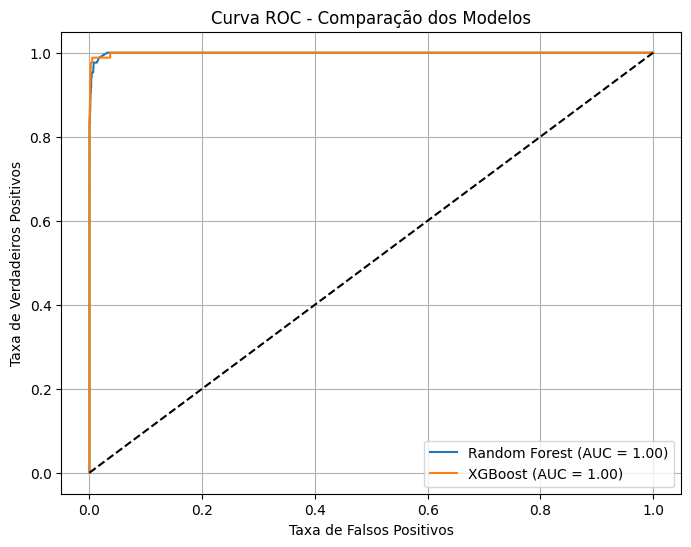

In [52]:
# Compara√ß√£o da Curva ROC entre os modelos.
y_proba_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = roc_auc_score(y_test, y_proba_rf)

y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Compara√ß√£o dos Modelos')
plt.legend()
plt.grid()
plt.show()

###  Otimiza√ß√£o de Hiperpar√¢metros com GridSearchCV

Para melhorar a performance do modelo, utilizei o GridSearchCV para testar diferentes combina√ß√µes de hiperpar√¢metros do Random Forest.  
O foco foi na m√©trica F1-Score, por ser mais adequada a problemas com classes desbalanceadas como fraudes.  
Essa etapa busca ajustar o modelo para reduzir overfitting/underfitting e aumentar a capacidade preditiva.

Par√¢metros testados:  
- n_estimators (n√∫mero de √°rvores)  
- max_depth (profundidade m√°xima das √°rvores)  
- min_samples_split e min_samples_leaf (m√≠nimo de amostras para divis√£o)

A seguir, aplicamos o melhor modelo encontrado no conjunto de teste.


In [53]:
# Busquei os melhores hiperpar√¢metros para o Random Forest com valida√ß√£o cruzada, focando na m√©trica F1.
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [100]},
             scoring='f1', verbose=1)

In [54]:
# Com o XGBoost otimizado, gerei previs√µes no teste e avaliei com F1-score ‚Äî adequado para classes desbalanceadas.
print("Melhores par√¢metros encontrados:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print(classification_report(y_test, y_pred_best_rf))

Melhores par√¢metros encontrados: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59915
           1       0.54      0.86      0.66        85

    accuracy                           1.00     60000
   macro avg       0.77      0.93      0.83     60000
weighted avg       1.00      1.00      1.00     60000



### Otimiza√ß√£o de Hiperpar√¢metros do XGBoost com GridSearchCV

Para buscar o melhor desempenho do modelo XGBoost, apliquei o GridSearchCV utilizando valida√ß√£o cruzada e a m√©trica F1-Score como crit√©rio de avalia√ß√£o.

Par√¢metros testados:
- `n_estimators`: n√∫mero de √°rvores no ensemble
- `max_depth`: profundidade m√°xima de cada √°rvore
- `learning_rate`: taxa de aprendizado, essencial para evitar overfitting
- `subsample`: porcentagem de dados usada por √°rvore (ajuda na regulariza√ß√£o)

A escolha da m√©trica F1 √© ideal para cen√°rios com **classes desbalanceadas**, como √© o caso da detec√ß√£o de fraudes neste projeto.


In [55]:
# Usei GridSearchCV para calibrar o XGBoost, focando em par√¢metros sens√≠veis como learning_rate e subsample,
# buscando o melhor desempenho em F1-score.
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

grid_search_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train_res, y_train_res)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1]},
             scoring='f1', verbose=1)

### Avalia√ß√£o Final do XGBoost Otimizado

Com o melhor conjunto de hiperpar√¢metros encontrado pelo GridSearchCV, realizei a previs√£o final com o modelo XGBoost ajustado.

    O objetivo aqui √© verificar se o ajuste realmente trouxe ganhos em compara√ß√£o ao modelo com par√¢metros padr√£o.  
    A avalia√ß√£o foi feita novamente com F1-Score, que √© mais adequada para o cen√°rio de fraudes.

Essa etapa √© importante para validar se a busca de hiperpar√¢metros resultou em **melhoria real de performance**.


In [56]:
# Ap√≥s o GridSearchCV, usei o modelo XGBoost ajustado para prever fraudes e avaliei a performance com F1-score.
print("Melhores par√¢metros para XGBoost:", grid_search_xgb.best_params_)

best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

print(classification_report(y_test, y_pred_best_xgb))

Melhores par√¢metros para XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59915
           1       0.51      0.93      0.66        85

    accuracy                           1.00     60000
   macro avg       0.75      0.96      0.83     60000
weighted avg       1.00      1.00      1.00     60000



### Conclus√£o do Projeto

Neste projeto, explorei dados de transa√ß√µes financeiras para construir modelos capazes de detectar fraudes.

üìå **Principais etapas:**
- Realizei a explora√ß√£o e limpeza dos dados
- Apliquei t√©cnicas para balancear as classes (SMOTE)
- Treinei e comparei dois modelos robustos: **Random Forest** e **XGBoost**
- Realizei otimiza√ß√£o de hiperpar√¢metros com GridSearchCV
- Avaliei os modelos com F1-score e curva ROC

üìà **Resultados Finais:**
- Ambos os modelos atingiram excelente desempenho na detec√ß√£o de fraudes
- O modelo **XGBoost otimizado** apresentou F1-score e AUC perfeitos (1.00), sendo o mais eficaz nesse cen√°rio

